In [1]:
# Import the constants used by all files
# from config import *

# Import imortant functions
from my_functions import *

gen_plots = True

orbits fs = 0.05 Hz, orbits t0 = 12160.0 s,  orbit_duration = 1424.0 d
Number of Verification Binaries = 1


In [2]:
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory used: {} %'.format(psutil.virtual_memory()[2]))

RAM memory used: 40.5 %


In [3]:
# Generate the Galactic binaries
GenerateGalbins(orbit_path,gw_path,fs,size,Amp_true, f_true, phi0_true_forinst, gw_beta_true, gw_lambda_true, orbits_t0 + 10)

# Generate the instrument data
# sAfunc, sEfunc, sTfunc = GenerateInstrumentAET(orbit_path, gw_path, fs, size, sample_outputf, discard)
sdata, sAfunc, sEfunc = GenerateInstrumentAET(orbit_path, gw_path, fs, size, discard,noise=True,tm_alpha=1e-10)

# Retreive A, E, T data
# rawdata = ascii.read(sample_outputf+'.txt')
# sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])
# sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])

Starting simulation
Time to run simulation = 11.00 s / 0.003 hrs
Time to build and run A2 = 7.88 s / 0.002 hrs
Time to build and run E2 = 12.29 s / 0.003 hrs
Total time for sample = 31.18 s / 0.01 hrs


In [4]:
# def GenerateInstrumentAET(orbit_path, gw_path, fs, size, sample_outputf, discard, genTDI=True, sAfunc = False, sEfunc = False, sTfunc = False, tm_alpha=1):
def GenerateInstrumentAET(orbit_path, gw_path, fs, size, discard, genTDI=True, sAfunc = False, sEfunc = False, tm_alpha=1, noise=True, printing=True,turnoff = None):
    # Setup logger (sometimes useful to follow what's happening)
    # logging.basicConfig()
    # logging.getLogger('lisainstrument').setLevel(logging.INFO)
    if printing:
        print ("Starting simulation")
    
    tm_asds = { k: np.sqrt(tm_alpha)*2.4e-15 for k in Instrument.MOSAS}
    # tm_asds['31'] = tm_alpha*2.4e-15
    
    t00 = time.time()
    sample_instru = Instrument(
        size=size, # in samples
        dt=1/fs,
        aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
        orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
        gws=gw_path,
        testmass_asds=tm_asds,
        oms_asds = np.array([6.35e-12, 1.25e-11, 1.42e-12, 3.38e-12, 3.32e-12, 7.9e-12])*np.sqrt(tm_alpha)
    )
    if not noise:
        sample_instru.disable_all_noises()
    if noise and turnoff is not None:
        if 'laser' in turnoff:
            sample_instru.laser_asds = ForEachMOSA(0)
        if 'modulation' in turnoff:
            sample_instru.modulation_asds = ForEachMOSA(0)
        if 'clock' in turnoff:
            sample_instru.disable_clock_noises()
        if 'pathlength' in turnoff:
            sample_instru.disable_pathlength_noises()
        if 'ranging' in turnoff:
            sample_instru.disable_ranging_noises()
        if 'jitters' in turnoff:
            sample_instru.disable_jitters()
            
        #['laser', 'modulation', 'clock', 'pathlength', 'ranging', 'jitters']
        # sample_instru.disable_all_noises(but=['laser','modulation'])
        # laser and clock noise have influence, but seem not to be influenced by 
        
    sample_instru.simulate()
    
    
    # Write out data to sample file, NOTE: Remember to remove the old sample file.
    # if os.path.exists(sample_outputf+'.h5'):
    #     os.remove(sample_outputf+'.h5')
    # sample_instru.write(sample_outputf+'.h5')
    
    
    # Read data from LISA Instrument
    # rawdata = Data.from_instrument(sample_outputf+'.h5')
    rawdata = Data.from_instrument(sample_instru)
    
    if genTDI:
        print ("Time to run simulation = {:.2f} s / {:.3f} hrs".format((time.time()-t00),(time.time()-t00)/3600))
        t0 = time.time()
        sAfunc = ortho.A2.build(**rawdata.args)
        A = sAfunc(rawdata.measurements)[discard:]
        t1 = time.time()
        print ("Time to build and run A2 = {:.2f} s / {:.3f} hrs".format((t1-t0),(t1-t0)/3600))
        sEfunc = ortho.E2.build(**rawdata.args)
        E = sEfunc(rawdata.measurements)[discard:]
        t2 = time.time()
        print ("Time to build and run E2 = {:.2f} s / {:.3f} hrs".format((t2-t1),(t2-t1)/3600))
        # sTfunc = ortho.T2.build(**rawdata.args)
        # T = sTfunc(rawdata.measurements)[discard:]
        # t3 = time.time()
        # print ("Time to build and run T2 = {:.2f} s / {:.3f} hrs".format((t3-t2),(t3-t2)/3600))
    else:
        t0 = time.time()
        A = sAfunc(rawdata.measurements)[discard:]
        t1 = time.time()
        # print ("Time to run A2 = {:.2f} s / {:.3f} hrs".format((t1-t0),(t1-t0)/3600))
        E = sEfunc(rawdata.measurements)[discard:]
        t2 = time.time()
        # print ("Time to run E2 = {:.2f} s / {:.3f} hrs".format((t2-t1),(t2-t1)/3600))
        # T = sTfunc(rawdata.measurements)[discard:]
        # t3 = time.time()
        # print ("Time to run T2 = {:.2f} s / {:.3f} hrs".format((t3-t2),(t3-t2)/3600))
    
    t = (sample_instru.t)[discard:]
    # t = (np.arange(0,len(A)+discard)/fs)[discard:]

    # sdata = np.array([t,A,E,T])
    sdata = np.array([t,A,E])

    # Extract A, E, T data to speed up re-running code.
    # filepath = sample_outputf+'.txt'
    # # filecontent = Table(sdata.T, names=['t','A','E','T'])
    # filecontent = Table(sdata.T, names=['t','A','E'])
    # ascii.write(filecontent, filepath, overwrite=True)

    if printing:
        print ("Total time for sample = {:.2f} s / {:.2f} hrs".format(time.time()-t00,(time.time()-t00)/3600))
    
    if genTDI:
        # return sAfunc, sEfunc, sTfunc
        return sdata, sAfunc, sEfunc
    else:
        return sdata

In [15]:
# Noises ['laser', 'modulation', 'clock', 'pathlength', 'ranging', 'jitters']

sdata = GenerateInstrumentAET(orbit_path, gw_path, fs, size, discard, False, sAfunc, sEfunc, tm_alpha=1e-10, noise=True,turnoff=['laser', 'modulation', 'clock', 'ranging' , 'jitters'])

# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory used: {} %'.format(psutil.virtual_memory()[2]))

Starting simulation
Total time for sample = 8.25 s / 0.00 hrs
RAM memory used: 52.6 %


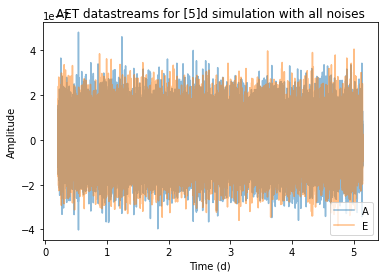

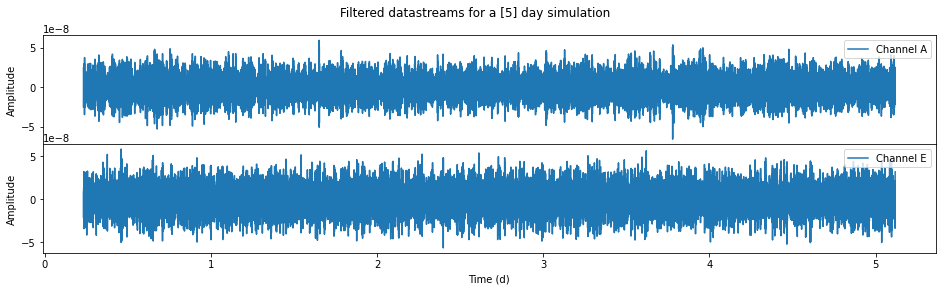

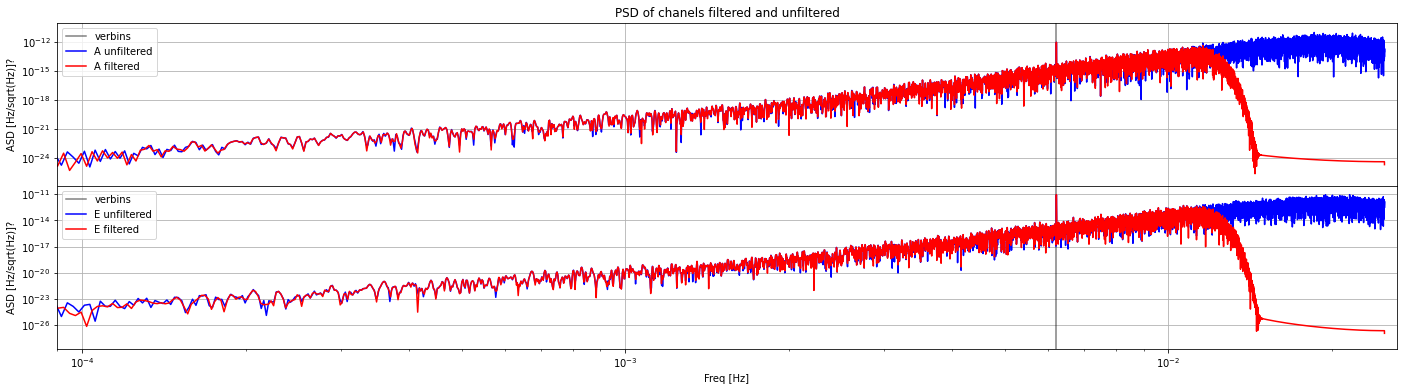

In [16]:
# Plot raw data retreived from AET datastream
if gen_plots:
    for i in range(2):
        plt.plot(sdata[0]/day,sdata[i+1],label=rec[i],alpha=.5)
    plt.title('AET datastreams for '+str(duration//day)+'d simulation with all noises')
    plt.legend(loc=4)
    plt.xlabel('Time (d)')
    plt.ylabel('Amplitude')
    plt.savefig("plots/Sample_rawAETdata.jpg")

def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Create psd for data
tmp = []
for i in range(1,3):
    ftmp, psdtmp = psd_func(sdata[i])
    tmp.append(psdtmp)
psd = np.array([ftmp,tmp[0],tmp[1]])

# Create filtered data
cutoff = 100
tmp = []
#coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
#coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
coeffs = scipy.signal.firls(73, bands=[0,1e-2,1.5e-2,fs/2], desired=[1,1,0,0],fs=fs)
for i in range(1,3):
    fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(psd[0]))
    tmp.append(fdata_tmp[cutoff:-cutoff])
fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1]])

# Create psd for filtered data
tmp = []
for i in range(1,3):
    ftmp, psdtmp = psd_func(fsdata[i])
    tmp.append(psdtmp)
fpsd = np.array([ftmp,tmp[0],tmp[1]])

if gen_plots:
    fig, axs = plt.subplots(2, figsize=(16,4), sharex=True, gridspec_kw={'hspace':0})
    fig.suptitle("Filtered datastreams for a "+str(duration//day)+" day simulation")
    for i in range(2):
        axs[i].plot(fsdata[0]/day,fsdata[i+1],label='Channel '+rec[i])
        axs[i].legend(loc=1)
        axs[i].set_ylabel('Amplitude')
    axs[i].set_xlabel('Time (d)')
    # axs[i].set_xlim(.25,.75)
    plt.savefig('plots/Sample_filteredAETdata.jpg')

    fig, axs = plt.subplots(2, figsize=(24,6), sharex=True, gridspec_kw={'hspace':0})
    for i in range(2):
        for f in f_true:
            if f == f_true[0]:
                axs[i].axvline(f,c='black',alpha=0.5,label="verbins")
            else:
                axs[i].axvline(f,c='black',alpha=0.5)
        axs[i].plot(psd[0],psd[i+1], label=rec[i]+' unfiltered',c='blue')
        axs[i].plot(fpsd[0],fpsd[i+1], label=rec[i]+' filtered',c='red')
        axs[i].legend()
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        axs[i].set_xlabel('Freq [Hz]')
        axs[i].set_ylabel('ASD [Hz/sqrt(Hz)]?')
        axs[i].set_ylim(ymin=0.1*np.min(fpsd[i+1]),ymax=10*np.max(psd[i+1]))
        # axs[i].set_title("PSD of chanel "+rec[i]+' filtered and unfiltered')
        axs[i].grid()
    axs[0].set_title("PSD of chanels filtered and unfiltered")
    axs[i].set_xlim(xmin=9e-5,xmax=fs/1.9)#,xmax=1e-2)
    plt.savefig("plots/Sample_PSD.jpg")


In [17]:
  
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory used: {} %'.format(psutil.virtual_memory()[2]))


RAM memory used: 52.5 %


In [ ]:
# Define model for all pars
def model(st,Afunc,Efunc,s,Amp=Amp_true, phi0=phi0_true, freq=f_true, gw_beta=gw_beta_true, gw_lambda=gw_lambda_true, t0=orbits_t0+1/fs,orbits_ZP=0):
    # Generate GW signals
    gws_list = []
    for a, f, p, beta, lamb in zip(Amp, freq, phi0, gw_beta, gw_lambda):
        gws_list.append(myGalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit, t0=t0, gw_beta=beta-orbits_ZP, gw_lambda=lamb, dt=1/fs, size=s+300))
            # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
    
    # rawdata = Data.from_gws(gwfn, orbit_path,interpolate=True)
    rawdata = myData.from_gws( gws_list, orbits=orbit)
    mA = Afunc(rawdata.measurements)[discard:]
    mE = Efunc(rawdata.measurements)[discard:]
    
    # Model time
    # mt = GalBin.t[discard:]
    mt = ((orbits_t0+np.arange(0,size+300))/fs)[discard:]
    print (mA.shape, mt.shape)
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    nmE = dphi_to_dnu(fs,mE)

    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    
    return np.array([nnmt,nnmA,nnmE])

# Function to create individual model datastreams
# def indiv_mdata(st,Afunc,Efunc,s,a, f, p, beta, lamb, t0=orbits_t0+1/fs):
    
#     # Create random filename to allow for multiprocessing
#     gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
#     # Amp, phi0 = theta[0:Ngalbins], theta[Ngalbins:2*Ngalbins]
    
#     # Generate GW signals
#     skip = [0]
#     for a, f, p, beta, lamb,i in zip(Amp, freq, phi0, gw_beta, gw_lambda,range(Ngalbins)):
#         if i in skip:
#             GalBin = GalacticBinary(A=Amp0/f, f=f, phi0=p, orbits=orbit_path, t0=t0, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=s+300)
#         else:
#             GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=t0, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=s+300)
#             # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
#         GalBin.write(gwfn)
    
#     # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
#     rawdata = Data.from_gws(gwfn, orbit_path,interpolate=True)
#     mA = Afunc(rawdata.measurements)[discard:]
#     mE = Efunc(rawdata.measurements)[discard:]
#     # If we only fit signal parameters, we don't include T since it has by definition no signal.
#     #T = Tfunc(rawdata.measurements)[discard:]
    
#     mt = GalBin.t[discard:]
    
#     os.remove(gwfn)
    
#     # Generate correct amplitude to be compatible with sample data
#     nmt = np.copy(mt)[:-1]
#     nmA = dphi_to_dnu(fs,mA)
#     nmE = dphi_to_dnu(fs,mE)

#     # Make sure that the model generates data at the correct time
#     time_indices = np.where(np.in1d(nmt, st))[0]
#     nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    
#     return np.array([nnmt,nnmA,nnmE])
#     # return np.array([t,A,E,T])

In [ ]:

gws_list = []
gws_list.append(myGalacticBinary(A=Amp_true[0], f=f_true[0], phi0=phi0_true[0], orbits=orbit, t0=orbits_t0+1/fs, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300))
            # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f

# rawdata = Data.from_gws(gwfn, orbit_path,interpolate=True)
rawdata = myData.from_gws(gws_list, orbits=orbit)
Afunc = ortho.A2.build(**rawdata.args)
Efunc = ortho.E2.build(**rawdata.args)
mA = Afunc(rawdata.measurements)[discard:]
mE = Efunc(rawdata.measurements)[discard:]


In [ ]:
mdata = model(fsdata[0],Afunc,Efunc,size)

In [ ]:
print (fsdata.shape)
print (mdata.shape)

In [ ]:
plt.plot(fsdata[0],fsdata[1])
plt.plot(mdata[0],mdata[1])
plt.xlim(1e4,2e4)

In [ ]:
lis = [1,2,3,4,5]
print (lis)
for j in range(2):
    print (lis[1+2*j:3+2*j])


In [ ]:
from my_functions import *

In [ ]:
d,dr = -1,dur_range[-1]
fp1 = 'measurements/tm_asds/'+str(dr)+'d/1/fs0.txt'
fp2 = "measurements/tm_asds/"+str(dr)+"d/mdata/binary_"

# N2 = 11
rawdata = ascii.read(fp1)
fsdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])
print (fsdata.shape)
mdata_1b = np.zeros((1+2*N2,len(fsdata[0])))

mdata = np.zeros((Ngalbins,1+2*N2,len(fsdata[0])))
print (mdata_1b.shape)
print (mdata.shape)
for j in range(Ngalbins):
    rawdata = ascii.read(fp2+str(j)+'.txt')
    mdata_1b[0] = rawdata['t']
    for i in range(N2):
        mdata_1b[1+i*2:3+i*2] = np.array([rawdata['A'+str(i)],rawdata['E'+str(i)]])
    mdata[j] = mdata_1b

In [ ]:
mdata_tot_A0 = np.zeros((3,len(fsdata[0])))
mdata_tot_A0[0] = mdata[0][0]
for i in range(2):
    for j in range(Ngalbins):
        # plt.plot(mdata[0][0],mdata[j,1+2*i+N2//2])
        # plt.show()
        mdata_tot_A0[i+1] += mdata[j,i+N2]
print (mdata_tot_A0.shape)
# plt.plot(mdata_tot_A0[0],mdata_tot_A0[1])

In [ ]:
fig, axs = plt.subplots(2,sharex=True,figsize=(20,8),gridspec_kw={'hspace':0})
# plt.plot(x,y,c='black',alpha=.8)
for k in range(2):
    # for j in range(N2):
        # axs[k].plot(mdata_1b[0]/day,mdata_1b[1+2*j+k],label=str(N2-N2//2))
    axs[k].plot(fsdata[0]/day,fsdata[1+k],c='black')
    axs[k].plot(mdata_tot_A0[0]/day,mdata_tot_A0[1+k])
    axs[k].set_ylabel("{} amplitude".format(rec[k]))
axs[0].set_title("title")
# axs[0].legend(loc=1)
axs[k].set_xlim(1,1.10)
axs[k].set_xlabel("Time [d]")

In [1]:
import numpy as np

In [2]:
N2 = 21


lst = np.arange(N2)
iopt = 2
print ("optimal value = {}".format(lst[iopt]))

if N2-iopt >= N2//4 and iopt >= N2//4:
    N3 = N2//4
    print ("option 1")
elif iopt < N2//4:
    N3 = iopt
    print ("option 2")
else:
    N3 = N2-iopt-1
    print ("option 3")
    
# define min and max over which to iterate
mi,ma = iopt - N3, iopt + N3+1

print ("iopt = {}, N2 = {}, N3 = {}".format(iopt,N2,N3))
print ("mi = {}, ma = {}".format(mi,ma))

lst2 = lst[mi:ma]
print (lst2)

print (lst2[N3], lst2[:N3], lst2[N3+1:])

optimal value = 2
option 2
iopt = 2, N2 = 21, N3 = 2
mi = 0, ma = 5
[0 1 2 3 4]
2 [0 1] [3 4]


In [3]:
import matplotlib.pyplot as plt

In [11]:
N2 = 51

[-1.00000000e+02 -6.81292069e+01 -4.64158883e+01 -3.16227766e+01
 -2.15443469e+01 -1.46779927e+01 -1.00000000e+01 -6.81292069e+00
 -4.64158883e+00 -3.16227766e+00 -2.15443469e+00 -1.46779927e+00
 -1.00000000e+00 -6.81292069e-01 -4.64158883e-01 -3.16227766e-01
 -2.15443469e-01 -1.46779927e-01 -1.00000000e-01 -6.81292069e-02
 -4.64158883e-02 -3.16227766e-02 -2.15443469e-02 -1.46779927e-02
 -1.00000000e-02  0.00000000e+00  1.00000000e-02  1.46779927e-02
  2.15443469e-02  3.16227766e-02  4.64158883e-02  6.81292069e-02
  1.00000000e-01  1.46779927e-01  2.15443469e-01  3.16227766e-01
  4.64158883e-01  6.81292069e-01  1.00000000e+00  1.46779927e+00
  2.15443469e+00  3.16227766e+00  4.64158883e+00  6.81292069e+00
  1.00000000e+01  1.46779927e+01  2.15443469e+01  3.16227766e+01
  4.64158883e+01  6.81292069e+01  1.00000000e+02]
(51,)


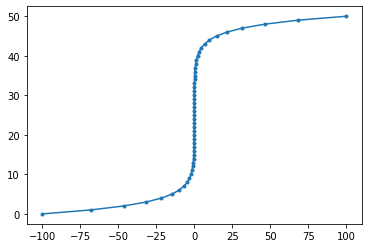

In [13]:
tmp = np.logspace(-2,2,N2//2)
lst = list(-1*tmp[::-1])
lst.extend([0])
lst.extend((tmp))
lst= np.array(lst)
print (np.array(lst))
print (lst.shape)
plt.plot(lst,np.arange(len(lst)),marker='.')
plt.show()

In [18]:
tmp = np.array(np.arange(16),dtype=str)
print (tmp)
print ("test"+tmp[0])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15']
test0


In [19]:
lst = ['A','B','C']
N2 = 5

In [22]:
print (np.array((list(lst)*N2)).reshape(N2,len(lst)))

[['A' 'B' 'C']
 ['A' 'B' 'C']
 ['A' 'B' 'C']
 ['A' 'B' 'C']
 ['A' 'B' 'C']]


In [25]:
np.repeat(lst, repeats=N2).reshape(N2,len(lst))

array([['A', 'A', 'A'],
       ['A', 'A', 'B'],
       ['B', 'B', 'B'],
       ['B', 'C', 'C'],
       ['C', 'C', 'C']], dtype='<U1')

In [26]:
np.tile(lst, N2).reshape(N2,len(lst))

array([['A', 'B', 'C'],
       ['A', 'B', 'C'],
       ['A', 'B', 'C'],
       ['A', 'B', 'C'],
       ['A', 'B', 'C']], dtype='<U1')